![](https://img.shields.io/pypi/l/PySR3)
![](https://img.shields.io/pypi/v/PySR3)
![](https://img.shields.io/github/actions/workflow/status/aksholokhov/pysr3/testing_and_coverage.yml?branch=master)
[![](https://img.shields.io/badge/docs-here-green)](https://aksholokhov.github.io/pysr3/)
[![codecov](https://codecov.io/gh/aksholokhov/pysr3/branch/master/graph/badge.svg?token=WAA8uIQwjK)](https://codecov.io/gh/aksholokhov/pysr3)
[![Codacy Badge](https://app.codacy.com/project/badge/Grade/749695b3c6fd43bb9fdb499ec0ace67b)](https://www.codacy.com/gh/aksholokhov/pysr3/dashboard?utm_source=github.com&amp;utm_medium=referral&amp;utm_content=aksholokhov/pysr3&amp;utm_campaign=Badge_Grade)

# Quickstart with `pysr3`

SR3 is a relaxation method designed for accurate feature selection.
It currently supports:

* Linear Models (L0, LASSO, A-LASSO, CAD, SCAD)
* Linear Mixed-Effect Models (L0, LASSO, A-LASSO, CAD, SCAD)

## Installation

pysr3 can be installed via
```bash
 pip install pysr3
```

In [1]:
from pysr3.__about__ import __version__
print(f"This tutorial was generated using PySR3 v{__version__}\n"
     "You might see slightly different numerical results if you are using a different version of the library.")

This tutorial was generated using PySR3 v0.3.2
You might see slightly different numerical results if you are using a different version of the library.


## Requirements
Make sure that Python 3.6 or higher is installed. The package has the following
dependencies, as listed in requirements.txt:

* numpy>=1.21.1
* pandas>=1.3.1
* scipy>=1.7.1
* PyYAML>=5.4.1
* scikit_learn>=0.24.2

## Usage
pysr3 models are fully compatible to [sklearn standards](https://scikit-learn.org/stable/developers/develop.html),
so you can use them as you normally would use a sklearn model.

### Linear Models
A simple example of using SR3-empowered LASSO for feature selection is shown below.

In [2]:
import numpy as np

from pysr3.linear.problems import LinearProblem

# Create a sample dataset
seed = 42
num_objects = 300
num_features = 500
np.random.seed(seed)
# create a vector of true model's coefficients
true_x = np.random.choice(2, size=num_features, p=np.array([0.9, 0.1]))
# create sample data
a = 10 * np.random.randn(num_objects, num_features)
b = a.dot(true_x) + np.random.randn(num_objects)

print(f"The dataset has {a.shape[0]} objects and {a.shape[1]} features; \n"
      f"The vector of true parameters contains {sum(true_x != 0)} non-zero elements out of {num_features}.")

The dataset has 300 objects and 500 features; 
The vector of true parameters contains 55 non-zero elements out of 500.


First, let's fit a model with a fixed parameter lambda:

In [3]:
from pysr3.linear.models import LinearL1ModelSR3
from sklearn.metrics import confusion_matrix
lam = 0.1*np.max(np.abs(a.T.dot(b)))
model = LinearL1ModelSR3(lam=lam, el=1e5)

In [4]:
%%timeit
model.fit(a, b)

37.4 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
maybe_x = model.coef_['x']
tn, fp, fn, tp = confusion_matrix(true_x, np.abs(maybe_x) > np.sqrt(model.tol_solver)).ravel()

print(f"The model found {tp} out of {tp + fn} features correctly, but also chose {fp} out of {tn+fp} extra irrelevant features. \n")

The model found 55 out of 55 features correctly, but also chose 5 out of 445 extra irrelevant features. 



Now let's see if we can improve it by adding grid-search:

In [6]:
# Automatic features selection using information criterion
from pysr3.linear.models import LinearL1ModelSR3
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

# Here we use SR3-empowered LASSO, but many other popular regularizers are also available
# See the glossary of models for more details.
model = LinearL1ModelSR3()
# We will search for the best model over the range of strengths for the regularizer
params = {
    "lam": loguniform(1e-1, 1e2)
}
selector = RandomizedSearchCV(estimator=model,
                              param_distributions=params,
                              n_iter=50,
                              # The function below evaluates an information criterion
                              # on the test portion of CV-splits.
                              scoring=lambda clf, x, y: -clf.get_information_criterion(x, y, ic='bic'))

selector.fit(a, b)
maybe_x = selector.best_estimator_.coef_['x']
tn, fp, fn, tp = confusion_matrix(true_x, np.abs(maybe_x) > np.sqrt(model.tol_solver)).ravel()

print(f"The model found {tp} out of {tp + fn} features correctly, but also chose {fp} out of {tn+fp} extra irrelevant features. \n"
      f"The best parameter is {selector.best_params_}")

The model found 55 out of 55 features correctly, but also chose 1 out of 445 extra irrelevant features. 
The best parameter is {'lam': 0.15055187290939537}


Note that the discovered coefficients will be biased downwards due to L1 regularization.

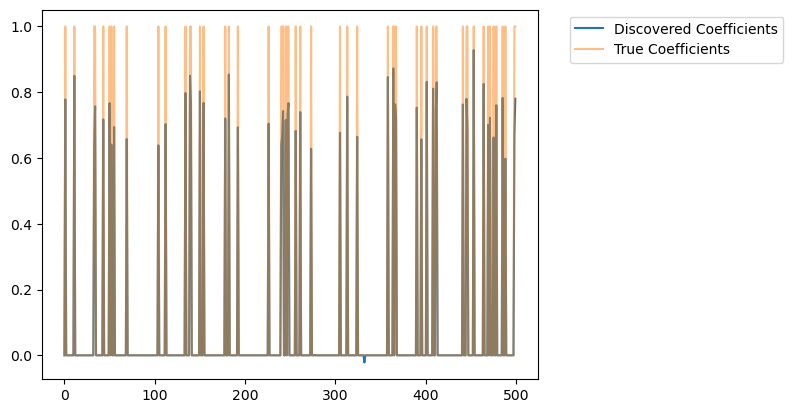

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
indep = list(range(num_features))
ax.plot(indep, maybe_x, label='Discovered Coefficients')
ax.plot(indep, true_x, alpha=0.5, label='True Coefficients')
ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()

You can get rid of the bias by refitting the model using only features that were selected.

### Linear Mixed-Effects Models

Below we show how to use Linear Mixed-Effects (LME) models for simultaneous selection
of fixed and random effects.

In [8]:
from pysr3.lme.models import L1LmeModelSR3
from pysr3.lme.problems import LMEProblem, LMEStratifiedShuffleSplit


# Here we generate a random linear mixed-effects problem.
# To use your own dataset check LMEProblem.from_dataframe and LMEProblem.from_x_y
problem, true_parameters = LMEProblem.generate(
    groups_sizes=[10] * 8,  # 8 groups, 10 objects each
    features_labels=["fixed+random"] * 20,  # 20 features, each one having both fixed and random components
    beta=np.array([0, 1] * 10),  # True beta (fixed effects) has every other coefficient active
    gamma=np.array([0, 0, 0, 1] * 5),  # True gamma (variances of random effects) has every fourth coefficient active
    obs_var=0.1,  # The errors have standard errors of sqrt(0.1) ~= 0.33
    seed=seed    # random seed, for reproducibility
)

# LMEProblem provides a very convenient representation
# of the problem. See the documentation for more details.

# It also can be converted to a more familiar representation
x, y, columns_labels = problem.to_x_y()
# columns_labels describe the roles of the columns in x:
# fixed effect, random effect, or both of those, as well as groups labels and observation standard deviation.

# You can also convert it to pandas dataframe if you'd like.
pandas_dataframe = problem.to_dataframe()

In [9]:
# We use SR3-empowered LASSO model, but many other popular models are also available.
# See the glossary of models for more details.
model = L1LmeModelSR3(practical=True)

# We're going to select features by varying the strength of the prior
# and choosing the model that yields the best information criterion
# on the validation set.
params = {
    "lam": loguniform(1e-3, 1e2),
    "ell": loguniform(1e-1, 1e2)
}
# We use standard functionality of sklearn to perform grid-search.
selector = RandomizedSearchCV(estimator=model,
                              param_distributions=params,
                              n_iter=30,  # number of points from parameters space to sample
                              # the class below implements CV-splits for LME models
                              cv=LMEStratifiedShuffleSplit(n_splits=2, test_size=0.5,
                                                           random_state=seed,
                                                           columns_labels=columns_labels),
                              # The function below will evaluate the information criterion
                              # on the test-sets during cross-validation.
                              # We use cAIC from Vaida, but other options (BIC, Muller's IC) are also available
                              scoring=lambda clf, x, y: -clf.get_information_criterion(x,
                                                                                       y,
                                                                                       columns_labels=columns_labels,
                                                                                       ic="vaida_aic"),
                              random_state=seed,
                              n_jobs=20
                              )
selector.fit(x, y, columns_labels=columns_labels)
best_model = selector.best_estimator_

maybe_beta = best_model.coef_["beta"]
maybe_gamma = best_model.coef_["gamma"]

# Since the solver stops witin sqrt(tol) from the minimum, we use it as a criterion for whether the feature
# is selected or not 
ftn, ffp, ffn, ftp = confusion_matrix(y_true=true_parameters["beta"],
                                      y_pred=abs(maybe_beta) > np.sqrt(best_model.tol_solver)
                                     ).ravel()
rtn, rfp, rfn, rtp = confusion_matrix(y_true=true_parameters["gamma"],
                                      y_pred=abs(maybe_gamma) > np.sqrt(best_model.tol_solver)
                                     ).ravel()

print(
    f"The model found {ftp} out of {ftp + ffn} correct fixed features, and also chose {ffp} out of {ftn + ffp} extra irrelevant fixed features. \n"
    f"It also identified {rtp} out of {rtp + rfn} random effects correctly, and got {rfp} out of {rtn + rfp} non-present random effects. \n"
    f"The best sparsity parameter is {selector.best_params_}")

The model found 10 out of 10 correct fixed features, and also chose 0 out of 10 extra irrelevant fixed features. 
It also identified 5 out of 5 random effects correctly, and got 0 out of 15 non-present random effects. 
The best sparsity parameter is {'ell': 0.3972110727381912, 'lam': 0.3725393839578885}


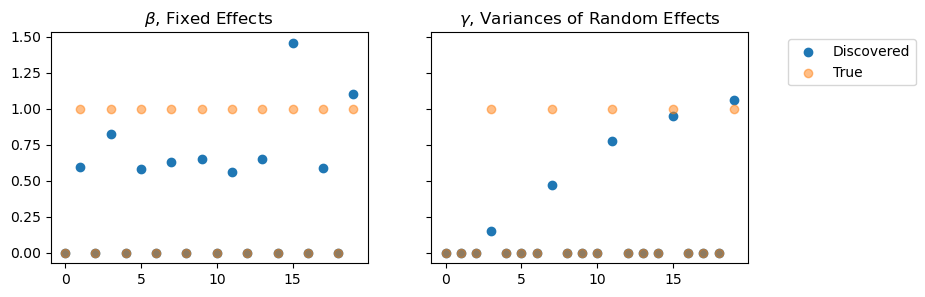

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)

indep_beta = list(range(np.size(true_parameters["beta"])))
indep_gamma = list(range(np.size(true_parameters["gamma"])))

axs[0].set_title(r"$\beta$, Fixed Effects")
axs[0].scatter(indep_beta, maybe_beta, label='Discovered')
axs[0].scatter(indep_beta, true_parameters["beta"], alpha=0.5, label='True')

axs[1].set_title(r"$\gamma$, Variances of Random Effects")
axs[1].scatter(indep_gamma, maybe_gamma, label='Discovered')
axs[1].scatter(indep_gamma, true_parameters["gamma"], alpha=0.5, label='True')
axs[1].legend(bbox_to_anchor=(1.55, 1))
plt.show()